In [2]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

from PIL import Image

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("using device: ", device)

using device:  cuda


In [3]:
# Load VGG net work from local / online
vgg = models.vgg19(pretrained=False)
vgg.load_state_dict(torch.load("vgg19-dcbb9e9d.pth"))
print(vgg)
vgg = vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
def ExtractFeatures(x, model, layers_need):
    """
        x: input batch
        model : the model used for getting features
        layers_need: int / dir for one layer and mutiple layers
    """
    features = []
    layer_input = x
    layer_out = None
    for i, layer in enumerate(model):
        layer_out = layer(layer_input)
        layer_input = layer_out
        
        if type(layers_need) == int and i == layers_need:
            return layer_out
        elif type(layers_need) == set and i in layers_need:
            features.append(layer_out)
    return features

def ExtractFeaturesGenerated(x, model, content_layer, styles):
    """
        x: input batch
        model : the model used for getting features
        layers_need: int / dir for one layer and mutiple layers
    """
    style_features = []
    content_feature = None
    layer_input = x
    layer_out = None
    for i, layer in enumerate(model):
        layer_out = layer(layer_input)
        layer_input = layer_out
        
        if i == content_layer:
            content_feature = layer_out
        if i in styles:
            style_features.append(layer_out)
            
    return content_feature, style_features
# TODO bug here
# test_img = Image.open("style.jpg")
# x = ImagePreprocess(test_img)
# content_layer = 2
# styles = {0, 10}
# m_test = torch.nn.Sequential(vgg.features[0], vgg.features[1], vgg.features[2], vgg.features[3])
# c1 = ExtractFeatures(x, m_test, content_layer)
# c2, s =  ExtractFeaturesGenerated(x,  m_test, content_layer, styles)
# print(c1 - c2)

In [5]:
def ContentLoss(weight, Foriginal, Fgenerated):
    """
        Foriginal, Fgenerated: The feature at specified layer
    """
    return weight * torch.sum(torch.pow(Foriginal - Fgenerated, 2))

def StyleRepresent(layer, normalize=True):
    """
        N : number of data (should be 1)
        Features : Number of features in that layer
        F_height, F_width : the size of features
    """
    N, Features, F_height, F_width = layer.shape
    
    F = layer.view(N, Features, F_height * F_width)
    Ft = F.transpose(1, 2)
    style = torch.matmul(F, Ft)
    if normalize:
        style /= (Features * F_height * F_width)
    return style

def StyleLoss(weightList, ForiginalList, FgeneratedList):
    """
        ForiginalList, FgeneratedList: list of features in orignal image and generated image at some layers we want
    """
    loss = 0
    for w, Fo, Fg in zip(weightList, ForiginalList, FgeneratedList):
        G = StyleRepresent(Fo)
        A = StyleRepresent(Fg)
        loss += w * torch.sum(torch.pow(G - A, 2))
    return loss

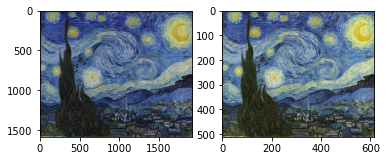

In [6]:
def ImagePreprocess(img, img_size=512):
    Trans = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = Trans(img)
    input_batch = input_tensor.unsqueeze(0)
    input_batch = input_batch.to(device)
    return input_batch

def ImageDeprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x[0]),
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
            std=[1/0.229, 1/0.224, 1/0.225]
        ),
        transforms.Lambda(rescale),
        transforms.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

# Test image pre/de process
test_img = Image.open("style.jpg")
t = ImagePreprocess(test_img, 512)
processed_img = ImageDeprocess(t)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(test_img)
axarr[1].imshow(processed_img)

In [7]:
def StyleTransfer(feature_model, paras):
    img_size = paras["img_size"]
    
    content_file = paras["content_file"]
    style_file = paras["style_file"]
    content_img = Image.open(content_file)
    style_img = Image.open(style_file)
    
    content_layer = paras["content_layer"]
    style_layers = paras["style_layers"]
    
    iterations_batch = paras["iterations_batch"]
    train_batch = paras["train_batch"]
    decay = paras["decay"]
    learning_rate = paras["lr"]
    
    style_weight = paras["style_weights"]
    content_weight = paras["content_weight"]

    content = ImagePreprocess(content_img, img_size)
    style =ImagePreprocess(style_img, img_size)

    
    content_feature = ExtractFeatures(content, feature_model, content_layer)
    style_features = ExtractFeatures(style, feature_model, style_layers)
    
    X = torch.rand(content.shape, requires_grad=True, device=device)
    # X = content.clone().detach()
    X = Variable(X, requires_grad=True)

    for batch in range(train_batch):
        optimizer = torch.optim.Adam([X], lr=learning_rate)
        for i in range(iterations_batch):

            generate_content, generate_style = ExtractFeaturesGenerated(X, feature_model, content_layer, style_layers)
            # TODO bug
            generate_content = ExtractFeatures(X, feature_model, content_layer)
            
            loss_style = StyleLoss(style_weight, style_features, generate_style)
            loss_content = ContentLoss(content_weight, content_feature, generate_content)

            loss = loss_style  + loss_content

            if i == 0:
                print(f"Loss at {batch}th iteration: {loss_style}, {loss_content}")
                
            # Backpropagation
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
        generated_img = ImageDeprocess(X.cpu())
        generated_img.save(f"result{batch}.png")
        learning_rate *= decay
    return X
        

In [ ]:
paras = {
    "img_size": 512,
    
    "content_file": "content.jpg",
    "style_file" : "style.jpg",
    
    "content_layer": 21,
    "style_layers": {0, 5, 10, 19, 28},
    
    "content_weight": 1e-6,
    "style_weights": [100, 100, 100, 0.1, 10],
    
    "iterations_batch": 100,
    "train_batch": 10,
    "lr": 0.1,
    "decay": 0.5
}
X = StyleTransfer(vgg.features, paras)

Loss at 0th iteration: 1246.9482421875, 167.58006286621094
Loss at 1th iteration: 20.030241012573242, 20.32684326171875
Loss at 2th iteration: 8.891151428222656, 10.069406509399414
Loss at 3th iteration: 7.805313587188721, 8.855022430419922
Loss at 4th iteration: 6.437060356140137, 7.621245861053467
Loss at 5th iteration: 6.1330790519714355, 7.2938551902771
Loss at 6th iteration: 5.733156204223633, 6.930788040161133
Loss at 7th iteration: 5.553121566772461, 6.745003700256348
Loss at 8th iteration: 5.462490081787109, 6.648336887359619
